# MCMC with `matryoshka` and `zeus`

In this example we demonstrate how to exploit the batch preidctions of `matryoshka` when runnig an MCMC with [`zeus`](https://zeus-mcmc.readthedocs.io/en/latest/).

We start by import all the packages required for this example.

In [1]:
import numpy as np
import matryoshka.emulator as Matry
import matryoshka.halo_model_funcs as MatryHM
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
import zeus
import time

Next we initalise the $T(k)$ component emulator. This is very simple and can be done with the `.Transfer()` emulator class. Upon initalisation all weights for the neual networks (NNs) are loaded meaning that no re-training is required before making predictions.

In [2]:
TransferEmu = Matry.Transfer()

We next select a cosmology at random from the `Matryoshka` test set. This randomly selected cosmology will be our "truth".

In [3]:
cache_dir = "/Path/to/matryoshka-data/"
# We load X_sigma instead of X_transfer here simply because it conatins all 7 cosmological parameters.
# X_transfer excludes sigma8 and ns.
valX = np.load(cache_dir+"class_aemulus/test/X_sigma-v3.npy")
valY = np.load(cache_dir+"class_aemulus/test/Y_transfer-v3.npy")

truth_id = np.random.choice(valX.shape[0])
truth_id

11

This random selection will of course be different each time the notbook is run, if you wish to use the same value that was used when this notbook was generated simply uncomment the line in the cell bellow.

In [4]:
#truth_id = 1872
COSMO_true = valX[truth_id]
Tk_true = valY[truth_id]
print("True cosmology:")
print("Om:{a}, Ob:{b}, sigma8:{c}, h:{d}, ns:{e}, Neff:{f}, w0:{g}".format(a=COSMO_true[0], b=COSMO_true[1],
                                                                           c=COSMO_true[2], d=COSMO_true[3],
                                                                           e=COSMO_true[4], f=COSMO_true[5], 
                                                                           g=COSMO_true[6]))

True cosmology:
Om:0.3283668107057938, Ob:0.051788977773701915, sigma8:0.7784588397824135, h:0.6470034896652331, ns:0.946203225476426, Neff:3.6307659580978444, w0:-0.9076985102035349


As a quick test we can see how the prediction from the $T(k)$ componenet emulator compares to the truth when the true cosmological parameters are used as input.

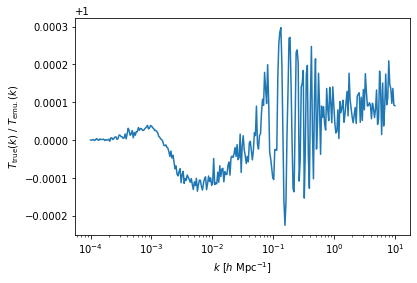

In [5]:
Tk_pred = TransferEmu.emu_predict(COSMO_true[[0,1,3,5,6]], mean_or_full="mean")

plt.semilogx(TransferEmu.kbins, Tk_true/Tk_pred[0], label = "Truth")
plt.xlabel(r"$k \ [h \ \mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$T_\mathrm{true}(k) \ / \ T_\mathrm{emu.}(k)$")
plt.show()

To generate a mock signal we can use in our MCMC, we calculate the linear matter power spectrum $P_L(k) = A_s k^{n_s}T^2(k)$. This is clearly an unrealistic example, the linear matter power spectrum is not something we will observe, it serves as a simple example that will convergence quickly whilst using all the cosmological parameters of our model.

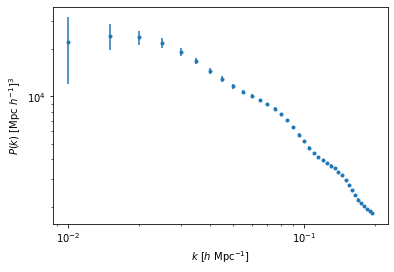

In [6]:
# Impose a range that would be more realistic if we were considering galaxy clustering.
k_obs = np.arange(0.01,0.2,0.005)

power_true = interp1d(TransferEmu.kbins, 
                      MatryHM.power0_v2(TransferEmu.kbins, Tk_true, sigma8=COSMO_true[2], ns=COSMO_true[4])[0])(k_obs)

# Define a very simple scale dependent measurement noise.
noise = k_obs**(-2)

plt.errorbar(k_obs, power_true, yerr=noise, linestyle='none', marker='.', zorder=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$k \ [h \ \mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$P(k) \ [\mathrm{Mpc} \ h^{-1}]^3$")
plt.show()

Now we can think about defining our prior and likelihood to be used in the MCMC.

For the prior we use a multivariate Gaussian prior that is defined by the `Matryoshka` training samples. This prior associates low probability to regions of the parameter space that are not covered by training data.

In [7]:
trainX = np.load(cache_dir+"class_aemulus/train/X_sigma-v3.npy")
mvn = multivariate_normal(trainX.mean(axis=0), np.cov(trainX, rowvar=False))

def log_prior(theta):
    return mvn.logpdf(theta[:,:])

Next we define a Gaussian likelihood with the form $$\ln{\mathcal{L}(d|\theta)}=-\frac{1}{2}\frac{(P-P'(\theta))^2}{\sigma^2}.$$

Where $P$ is our `power_true`, $P'(\theta)$ is the emulator prediction for the parameters $\theta$, and $\sigma$ is our `noise`. We construct this function such that it expects multiple parameter sets to evaluate, exploiting the batch prediction speed from `Matryoshka`.

In [8]:
def log_like(theta, obs_pow, noise):
    preds_T = TransferEmu.emu_predict(theta[:,[0,1,3,5,6]], mean_or_full='mean')
    
    preds_power = interp1d(TransferEmu.kbins, MatryHM.power0_v2(TransferEmu.kbins, preds_T, sigma8=theta[:,2],
                                                                ns=theta[:,4]))(k_obs)
    
    res = obs_pow - preds_power
    
    return -0.5*np.sum(res**2/noise**2, axis=1)

The final function we need before runnig our MCMC combines the log-likelihood and the log-prior to calculate the log-probability.

In [9]:
def log_prob(theta, obs_pow, noise):
    theta = np.array(theta)
    lp = log_prior(theta)
    ll = log_like(theta, obs_pow, noise)
    return ll+lp

# We also define a function for the negative log_prob, this will be used with the minimize function from scipy so
# does not exploit batch predictions.
def neg_log_prob(theta, obs_pow, icov):
    theta = theta.reshape(1, -1)
    return -(log_prob(theta, obs_pow, icov))

As the title of this notebook suggests, we will be using `zeus` to do our MCMC. `zeus` is an ensemble sampler, as such requires us to generate inital positions for ensemble of walkers. For this example we generate the walker positions as small perturbations from the maximum likelihood position.

In [10]:
results = minimize(neg_log_prob, trainX.mean(axis=0), args=(power_true, noise),
                   options={'disp': True, "maxiter": 100000}, method='Nelder-Mead')
print("Maximum likelihood cosmology:")
print("Om:{a}, Ob:{b}, sigma8:{c}, h:{d}, ns:{e}, Neff:{f}, w0:{g}".format(a=results.x[0], b=results.x[1],
                                                                           c=results.x[2], d=results.x[3],
                                                                           e=results.x[4], f=results.x[5], 
                                                                           g=results.x[6]))
print("===================")
print("True cosmology:")
print("Om:{a}, Ob:{b}, sigma8:{c}, h:{d}, ns:{e}, Neff:{f}, w0:{g}".format(a=COSMO_true[0], b=COSMO_true[1],
                                                                           c=COSMO_true[2], d=COSMO_true[3],
                                                                           e=COSMO_true[4], f=COSMO_true[5], 
                                                                           g=COSMO_true[6]))

init_pos = results.x+1e-3*np.random.randn(20, 7)

Optimization terminated successfully.
         Current function value: -18.762019
         Iterations: 338
         Function evaluations: 545
Maximum likelihood cosmology:
Om:0.3231318382788172, Ob:0.051286636108359304, sigma8:0.778846227147453, h:0.6586413230566219, ns:0.9549306010088633, Neff:3.84823939233073, w0:-0.9399051491349184
True cosmology:
Om:0.3283668107057938, Ob:0.051788977773701915, sigma8:0.7784588397824135, h:0.6470034896652331, ns:0.946203225476426, Neff:3.6307659580978444, w0:-0.9076985102035349


We can now run our MCMC, we run for 1000 steps, this should be more that $10\times$ the autocorrelation time for most examples.

In [11]:
sampler = zeus.EnsembleSampler(20, 7, log_prob, args=(power_true, noise), vectorize=True)
start = time.time()
sampler.run_mcmc(init_pos, 1000, progress=True)
end = time.time()
print("{a} likelihood evaluations in {b} minutes.".format(a=sampler.ncall, b=np.round((end-start)/60,1)))

Initialising ensemble of 20 walkers...
Sampling progress : 100%|██████████| 1000/1000 [02:12<00:00,  7.53it/s]

98964 likelihood evaluations in 2.2 minutes.


Once the MCMC has finished we can examine our chains are resulting posterior distributions.

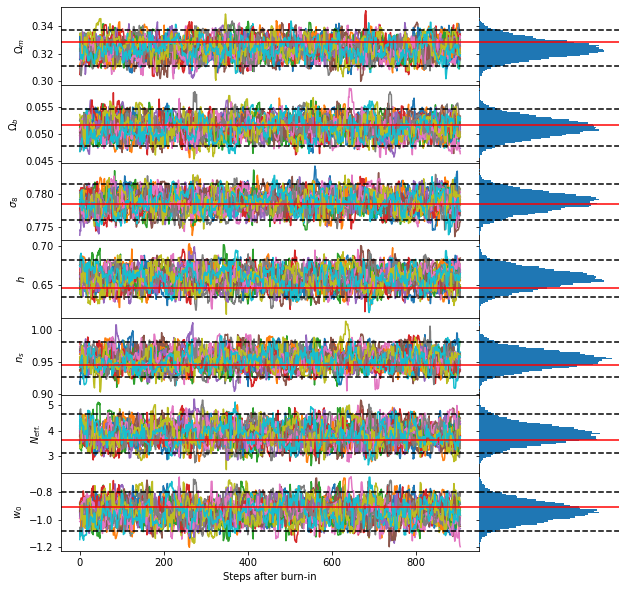

In [12]:
# For this example we say that the chain is burnt-in once we have reached more than 5X the autocorrelation time.
# We only keep the samples after we have burnt-in.
chain = sampler.get_chain(flat=False, discard=int(sampler.act.max()*5))

fig, ax = plt.subplots(7,2, figsize=(10,10), gridspec_kw={'width_ratios':[3,1]}, sharex='col', sharey='row')

labels = [r"$\Omega_m$", r"$\Omega_b$", r"$\sigma_8$", r"$h$", r"$n_s$", r"$N_\mathrm{eff.}$", r"$w_0$"]
for i in range(7):
    ax[i,0].plot(chain[:,:,i])
    ax[i,0].set_ylabel(labels[i])
    ax[i,1].hist(chain[:,:,i].flatten(),bins=50, orientation='horizontal')
    ax[i,1].set_frame_on(False)
    ax[i,1].set_xticks([])
    for j in range(2):
        ax[i,j].axhline(COSMO_true[i], color='red')
        for q in [0.025, 0.975]:
            ax[i,j].axhline(np.quantile(chain[:,:,i].flatten(), q), color='k', linestyle='--')

ax[-1,0].set_xlabel("Steps after burn-in")
plt.subplots_adjust(hspace=0., wspace=0.)
plt.show()